Epoch 1/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5230 - loss: 0.8742 - val_accuracy: 0.6560 - val_loss: 0.8094
Epoch 2/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6639 - loss: 0.7804 - val_accuracy: 0.6770 - val_loss: 0.7823
Epoch 3/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6749 - loss: 0.7371 - val_accuracy: 0.6860 - val_loss: 0.7710
Epoch 4/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6850 - loss: 0.7293 - val_accuracy: 0.6921 - val_loss: 0.7669
Epoch 5/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6907 - loss: 0.7435 - val_accuracy: 0.6957 - val_loss: 0.7632
Epoch 6/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6921 - loss: 0.7477 - val_accuracy: 0.6976 - val_loss: 0.7621
Epoch 7/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6978 - loss: 0.7183 - val_accuracy: 0.6971 - val_loss: 0.7610
Epoch 8/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6977 - loss: 0

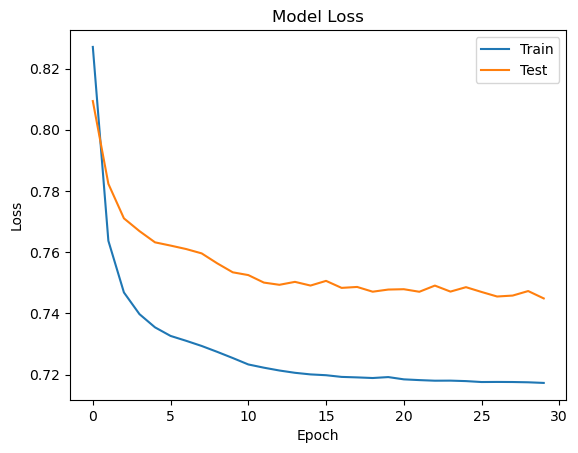

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step


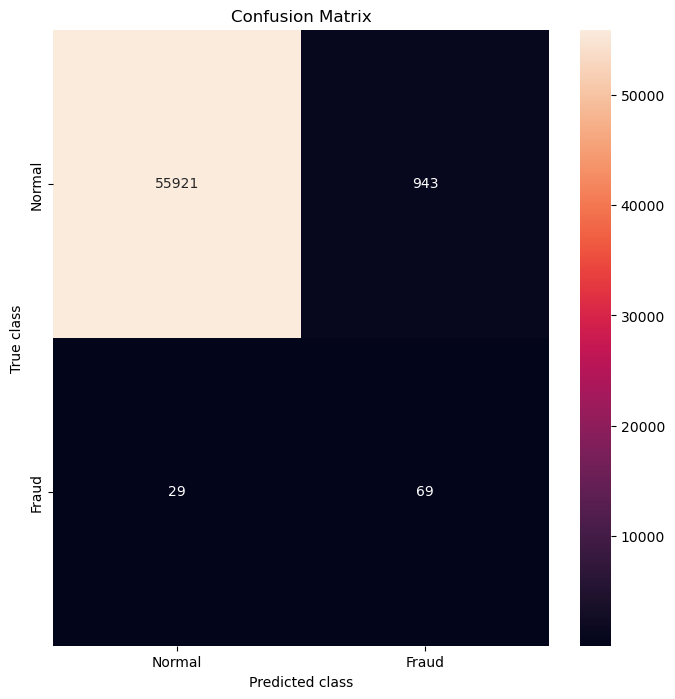

Accuracy: 0.9829359924159966
Recall: 0.7040816326530612
Precision: 0.06818181818181818


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Load dataset
df = pd.read_csv(r"C:\Users\91721\Desktop\Future Useful Study Material\DL\creditcard.csv")

# Preprocessing: drop 'Time' and scale 'Amount'
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# Split dataset into training and testing
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0].drop(['Class'], axis=1).values
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1).values

# Autoencoder model definition
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model
history = autoencoder.fit(X_train, X_train, epochs=30, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Anomaly detection and reconstruction error
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

# Dynamic threshold based on reconstruction error distribution
threshold = np.mean(error_df.reconstruction_error) + np.std(error_df.reconstruction_error)

# Classify anomalies
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error]

# Confusion matrix and evaluation metrics
conf_matrix = confusion_matrix(error_df['true_class'], y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Performance metrics
print("Accuracy:", accuracy_score(error_df['true_class'], y_pred))
print("Recall:", recall_score(error_df['true_class'], y_pred))
print("Precision:", precision_score(error_df['true_class'], y_pred))
